# Predictive Analysis Project: Used Car Price Prediction (VW Gol)

**Objective:** To create a Machine Learning model to predict the price of a used Volkswagen Gol based on its features, such as year and mileage.

**Workflow:**
1.  **Data Collection:** Scraping data from real advertisements on Mercado Livre using Web Scraping.
2.  **Storage:** Persisting the collected data in a MySQL database.
3.  **Exploratory Data Analysis (EDA):** Cleaning, analyzing correlations, distributions, and similarities within the data.
4.  **Predictive Modeling:** Building and evaluating a Linear Regression model.
5.  **Visualization:** Visually presenting the results and the model.

### Step 0: Installing the Libraries

If you are running this notebook for the first time in a new environment, you might need to install the libraries it uses. Uncomment and run the code cell below to install all the required dependencies.

In [29]:
# Uncomment and run this line ONLY if you do not have the libraries installed.
 !pip install requests numpy os re json beautifulsoup4 pandas scipy mysql-connector-python SQLAlchemy seaborn scikit-learn matplotlib

IndentationError: unexpected indent (2144223298.py, line 2)

In [17]:
# Cell for importing all necessary libraries
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import os
import json
import mysql.connector
from sqlalchemy import create_engine
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from scipy.spatial.distance import cdist
from scipy.spatial.distance import euclidean

print("Libraries imported successfully!")

Libraries imported successfully!


## Phase 1: Data Collection (Web Scraping)

In this stage, we will extract data directly from the Mercado Livre website. We will use the `requests` library to access the page and `BeautifulSoup` to parse the HTML and find the information in each listing.

In [8]:
import requests
import os
from bs4 import BeautifulSoup
import re
import json
import pandas as pd

url = "https://lista.mercadolivre.com.br/veiculos/carros-caminhonetes/gol"

# Headers to simulate a browser and avoid blocking
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/116.0.0.0 Safari/537.36'
}

def clean_price(price_str):
    """Removes 'R$' and thousand separators, converts to integer."""
    if not price_str:
        return 0
    numbers = re.findall(r'\d+', price_str)
    return int("".join(numbers)) if numbers else 0

def clean_km(km_str):
    """Removes 'km' and thousand separators, converts to integer."""
    if not km_str:
        return 0
    numbers = re.findall(r'\d+', km_str)
    return int("".join(numbers)) if numbers else 0

def clean_year(string):
    """Extracts the year from the title."""
    match = re.search(r'(11|12|13|14|15|16|17|18|19|20|21|22|23|24|25)\d{2}', string)
    if match:
        return int(match.group(0))
    else:
        return None

def get_city_state(location, arg):
    """Splits location into city and state."""
    city, state = location.split('-')
    if arg == 'city':
        return city
    if arg == 'state':
        return state

try:
    response = requests.get(url, headers=headers, timeout=10)
    response.raise_for_status()  # Check if the request was successful

    print("Request successful! Processing content...")
    soup = BeautifulSoup(response.content, 'html.parser')

    ads = soup.find_all('div', class_='ui-search-result__wrapper')
    
    car_data = []
    for ad in ads:
        try:
            car_info = {}

            # --- Extracting the Title ---
            title_element = ad.find('a', class_='poly-component__title')
            car_info['title'] = title_element.text.strip() if title_element else 'N/A'
            car_info['year'] = clean_year(car_info['title']) if title_element else 'N/A'

            # --- Extracting Price ---
            price_element = ad.find('div', class_='poly-component__price')
            price_str = price_element.text.strip() if price_element else '0'
            car_info['price'] = clean_price(price_str)

            # --- Extracting Year and Mileage ---
            attributes_elements = ad.find_all('div', class_='poly-component__attributes-list')
            km_str = attributes_elements[0].text.strip() if len(attributes_elements) > 0 else '0'
            car_info['mileage'] = clean_km(km_str)

            # --- Extracting Location ---
            location_element = ad.find('span', class_='poly-component__location')
            car_info['location'] = location_element.text.strip() if location_element else 'N/A'
            car_info['city'] = get_city_state(car_info['location'], 'city')
            car_info['state'] = get_city_state(car_info['location'], 'state')
            
            car_data.append(car_info)

        except (AttributeError, IndexError, ValueError) as e:
            print(f"Error processing an ad: {e}. Skipping...")
            continue
    
except requests.exceptions.RequestException as e:
    print(f"HTTP request failed: {e}")
except Exception as e:
    print(f"Unexpected error occurred: {e}")

# --- Convert to DataFrame ---
df = pd.DataFrame(car_data)
print(df.info())

# Rename columns and clean DataFrame
df = df.rename(columns={"price": "price"})
df = df.drop('location', axis=1)
df.dropna(subset=['year'], inplace=True)
df['year'] = df['year'].astype(int)

# Save CSV
df.to_csv('dados_gol_2025.csv', index=False)

df = pd.read_csv(os.path.join(os.getcwd(), 'dados_gol_2025.csv'))

Request successful! Processing content...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     48 non-null     object
 1   year      48 non-null     int64 
 2   price     48 non-null     int64 
 3   mileage   48 non-null     int64 
 4   location  48 non-null     object
 5   city      48 non-null     object
 6   state     48 non-null     object
dtypes: int64(3), object(4)
memory usage: 2.8+ KB
None


##### here we are exploring the data using csv to ensure that the code will work as expected.

## Phase 2: Database Storage

With the collected data in a DataFrame, the next step is to store it permanently in a MySQL database. This ensures we don't lose the data and allows it to be accessed by other applications in the future.

**Note:** The code cell below will connect to your local database. Make sure the MySQL service is running and that the credentials (user, password, database name) are correct. The data insertion (`df.to_sql`) is commented out to prevent accidental executions.

In [9]:
# --- MySQL Connection and Insertion ---
# REPLACE WITH YOUR CREDENTIALS
db_user = "root"
db_password = "your_password_here" 
db_host = "localhost"
db_name = "cars_db"

# Creating the connection with SQLAlchemy
try:
    engine = create_engine(f"mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}")
    
    # Use the code below to save the DataFrame to the database.
    # Uncomment the df.to_sql line to execute the insertion.
    # if_exists='append' adds new data without deleting the old data.
    
    # df.to_sql(name="gol_listings", con=engine, if_exists="append", index=False)
    
    print("Connection to the database was successful.")
    print("If you wish, uncomment the 'df.to_sql' line to save the data to MySQL.")

except Exception as e:
    print(f"An error occurred while connecting to the database: {e}")

Connection to the database was successful.
If you wish, uncomment the 'df.to_sql' line to save the data to MySQL.


## Phase 3: Exploratory Data Analysis (EDA)

Now, we will load the data (from the DataFrame in memory, for simplicity) and explore it to understand its characteristics, relationships, and identify potential outliers.

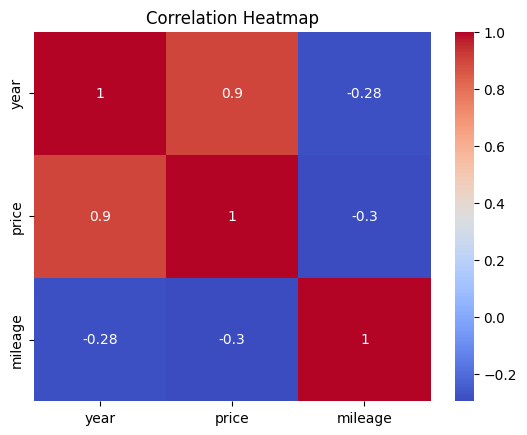

In [10]:
# --- Correlation and heatmap ---
numeric_cols = df.select_dtypes(include='number')
corr = numeric_cols.corr()

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

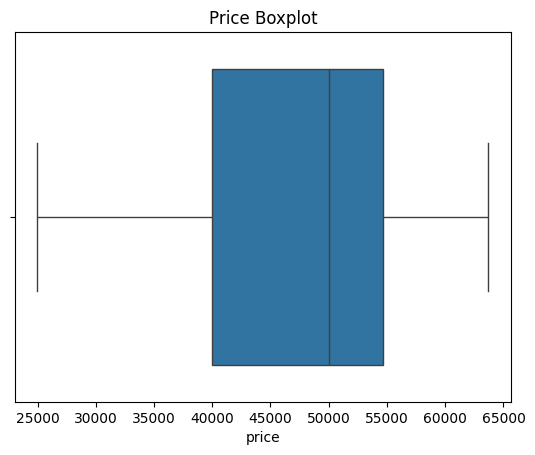


Means:
 year      2018.770833
price    48164.437500
dtype: float64


In [12]:
# --- Check for outliers ---
sns.boxplot(x=df['price'])
plt.title("Price Boxplot")
plt.show()

# --- Mean of year and price ---
mean_values = df[['year', 'price']].mean()
print("\nMeans:\n", mean_values)

## Phase 4: Preprocessing for Modeling and Similarity Analysis

Before building the model, we will normalize the data. This puts all variables on the same scale (between 0 and 1), which is essential for distance-based algorithms. We'll use this normalized data to calculate the "distance" or "similarity" between each car.

In [15]:
# --- Normalization within the DataFrame ---
scaler = MinMaxScaler()
df[['year_norm', 'price_norm']] = scaler.fit_transform(df[['year', 'price']])

In [18]:
# --- Euclidean distance between the first two cars (normalized features) ---
d = euclidean(
    df.loc[0, ['year_norm', 'price_norm']],
    df.loc[1, ['year_norm', 'price_norm']]
)
print("Euclidean distance between the first two cars:", d)

Euclidean distance between the first two cars: 0.5444888355231375


In [19]:
# --- Pairwise distances for all cars ---
features = df[['year_norm', 'price_norm']].astype(float).dropna()
features_array = features.values

distance_matrix = cdist(features_array, features_array, metric='euclidean')
dist_df = pd.DataFrame(distance_matrix, index=features.index, columns=features.index)

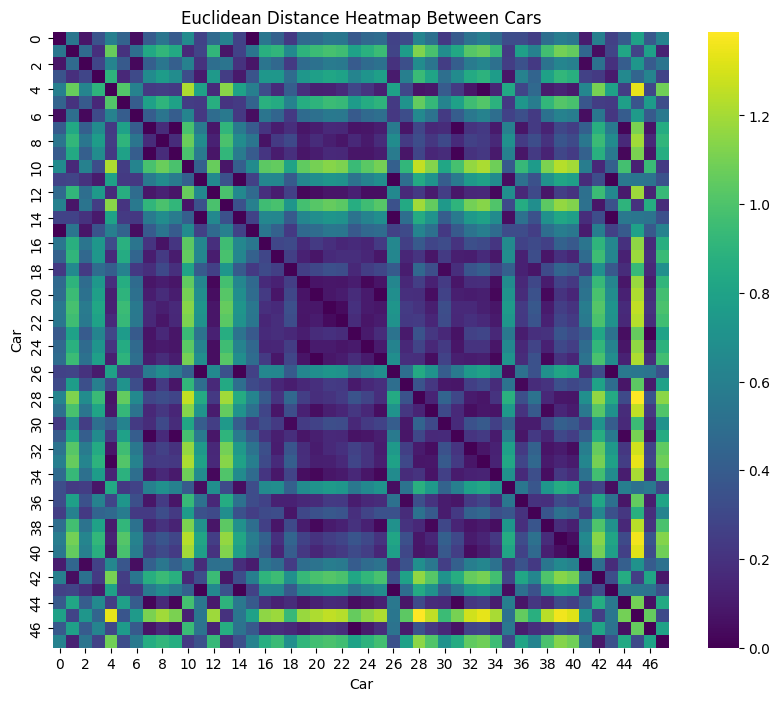

In [21]:
# --- Visualize similarity between cars ---
plt.figure(figsize=(10, 8))
sns.heatmap(dist_df, cmap='viridis', square=True)
plt.title('Euclidean Distance Heatmap Between Cars')
plt.xlabel('Car')
plt.ylabel('Car')
plt.show()

## Phase 5: Predictive Modeling (Linear Regression)

Finally, we will build our Linear Regression model. The goal is to train a model that learns the relationship between a car's **year** and its **price**, so we can predict the price of cars based on this feature.

In [23]:
# --- Linear Regression ---
X = df[['year']].astype(float)
y = df['price'].astype(float)

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

print("Coefficient (slope):", model.coef_[0])
print("Intercept:", model.intercept_)
print("R²:", model.score(X, y))

Coefficient (slope): 2284.681413904539
Intercept: -4564083.764349245
R²: 0.815296432417275


In [24]:
# --- Prediction for 2026 ---
future_year = [[2026]]
future_price = model.predict(future_year)
print(f"\nPredicted price for 2026: {future_price[0]:.2f}")



Predicted price for 2026: 64680.78


C:\Users\ayuki\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


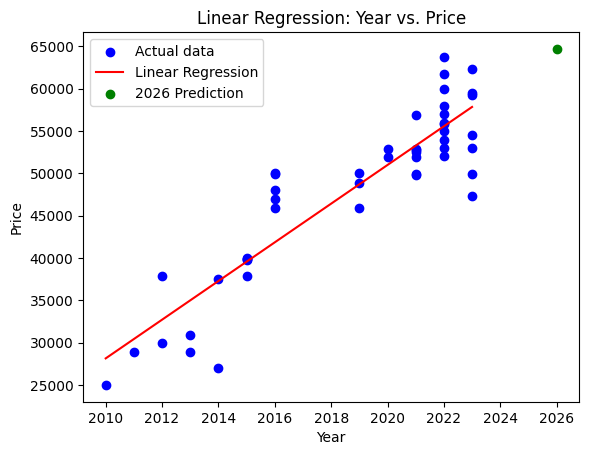

In [26]:
# --- Sort X for plotting ---
# Convert to numeric and drop NaNs
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df = df.dropna(subset=['year', 'price', 'mileage'])

X_sorted = X.sort_values(by='year')
y_pred_sorted = model.predict(X_sorted)

# --- Final regression plot ---
plt.scatter(X, y, color='blue', label='Actual data')
plt.plot(X_sorted, y_pred_sorted, color='red', label='Linear Regression')
plt.scatter(future_year, future_price, color='green', label='2026 Prediction')

plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Linear Regression: Year vs. Price')
plt.legend()
plt.show()


## Conclusion

This notebook has successfully demonstrated a complete data project workflow, from collecting raw data from the web to building and evaluating a predictive model. The Linear Regression model showed a strong positive correlation between the vehicle's year and its price, as validated by the R² score and the graphical visualization.